In [2]:
from pathlib import Path
from datetime import datetime, timedelta, date
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import missingno as msno
from zoneinfo import ZoneInfo
import matplotlib.dates as mdates

In [3]:
# load data
data_path = Path('../database/i10-broadway')
# X_tensor = np.load(data_path / 'X_tensor_1h.npz', allow_pickle=True)['X_tensor']
X_full = pd.read_parquet(data_path / 'X_full_1h.parquet')

# Peek shapes/types to guide later steps
# print('X_tensor type:', type(X_tensor), 'shape:', getattr(X_tensor, 'shape', None))
print('X_full   type:', type(X_full), 'shape:', getattr(X_full, 'shape', None))

X_full   type: <class 'pandas.core.frame.DataFrame'> shape: (119300, 10)


## Add more features related 
#### periodicity - Cyclical Encoding (sine–cosine features)

In [4]:
# Extract time level
time_index = X_full.index.get_level_values('time_bin')

# Add hour and day-of-week features directly to X_full
events_col = ['evt_cat_major', 'evt_cat_minor', 'evt_cat_closure', 'evt_cat_obstruction', 'evt_cat_misc']
X_full = X_full.assign(
    hour_sin = np.sin(2 * np.pi * time_index.hour / 24),
    hour_cos = np.cos(2 * np.pi * time_index.hour / 24),
    dow_sin  = np.sin(2 * np.pi * time_index.dayofweek / 7),
    dow_cos  = np.cos(2 * np.pi * time_index.dayofweek / 7),
    hour_of_week = time_index.dayofweek * 24 + time_index.hour,
    hour_of_week_sin = np.sin(2 * np.pi * (time_index.dayofweek * 24 + time_index.hour) / (7 * 24)),
    hour_of_week_cos = np.cos(2 * np.pi * (time_index.dayofweek * 24 + time_index.hour) / (7 * 24)),
    is_weekend = (time_index.dayofweek >= 5).astype(int),
    evt_total = X_full[events_col].sum(axis=1),
    speed_ratio = X_full['speed'] / X_full['reference_speed']
)
X_full.head()

speed  travel_time_seconds  \
tmc_code  time_bin                                                    
115+04177 2025-06-16 00:00:00+00:00  70.133333             7.598167   
          2025-06-16 01:00:00+00:00  69.583333             7.665000   
          2025-06-16 02:00:00+00:00  67.300000             7.950667   
          2025-06-16 03:00:00+00:00  71.933333             7.411000   
          2025-06-16 04:00:00+00:00  71.816667             7.422000   

                                     reference_speed  evt_duration  \
tmc_code  time_bin                                                   
115+04177 2025-06-16 00:00:00+00:00             70.0           0.0   
          2025-06-16 01:00:00+00:00             70.0           0.0   
          2025-06-16 02:00:00+00:00             70.0           0.0   
          2025-06-16 03:00:00+00:00             70.0           0.0   
          2025-06-16 04:00:00+00:00             70.0           0.0   

                                     evt_cat_major  evt_cat_minor  \
tmc_code  time_bin                                                  
115+04177 2025-06-16 00:00:00+00:00            0.0            0.0   
          2025-06-16 01:00:00+00:00            0.0            0.0   
          2025-06-16 02:00:00+00:00            0.0            0.0   
          2025-06-16 03:00:00+00:00            0.0            0.0   
          2025-06-16 04:00:00+00:00            0.0            0.0   

                                     evt_cat_closure  evt_cat_obstruction  \
tmc_code  time_bin                                                          
115+04177 2025-06-16 00:00:00+00:00              0.0                  0.0   
          2025-06-16 01:00:00+00:00              0.0                  0.0   
          2025-06-16 02:00:00+00:00              0.0                  0.0   
          2025-06-16 03:00:00+00:00              0.0                  0.0   
          2025-06-16 04:00:00+00:00              0.0                  0.0   

                                     evt_cat_misc     miles  hour_sin  \
tmc_code  time_bin                                                      
115+04177 2025-06-16 00:00:00+00:00           0.0  0.147902  0.000000   
          2025-06-16 01:00:00+00:00           0.0  0.147902  0.258819   
          2025-06-16 02:00:00+00:00           0.0  0.147902  0.500000   
          2025-06-16 03:00:00+00:00           0.0  0.147902  0.707107   
          2025-06-16 04:00:00+00:00           0.0  0.147902  0.866025   

                                     hour_cos  dow_sin  dow_cos  hour_of_week  \
tmc_code  time_bin                                                              
115+04177 2025-06-16 00:00:00+00:00  1.000000      0.0      1.0             0   
          2025-06-16 01:00:00+00:00  0.965926      0.0      1.0             1   
          2025-06-16 02:00:00+00:00  0.866025      0.0      1.0             2   
          2025-06-16 03:00:00+00:00  0.707107      0.0      1.0             3   
          2025-06-16 04:00:00+00:00  0.500000      0.0      1.0             4   

                                     hour_of_week_sin  hour_of_week_cos  \
tmc_code  time_bin                                                        
115+04177 2025-06-16 00:00:00+00:00          0.000000          1.000000   
          2025-06-16 01:00:00+00:00          0.037391          0.999301   
          2025-06-16 02:00:00+00:00          0.074730          0.997204   
          2025-06-16 03:00:00+00:00          0.111964          0.993712   
          2025-06-16 04:00:00+00:00          0.149042          0.988831   

                                     is_weekend  evt_total  speed_ratio  
tmc_code  time_bin                                                       
115+04177 2025-06-16 00:00:00+00:00           0        0.0     1.001905  
          2025-06-16 01:00:00+00:00           0        0.0     0.994048  
          2025-06-16 02:00:00+00:00           0        0.0     0.961429  
          2025-06-16 03:00:00+00:00           0     

#### Add lag features

In [5]:
def add_lag_features(df, target_col='travel_time_seconds', lags=[1, 2, 3]):
    # df = df.copy()
    for lag in lags:
        df[f'lag{lag}'] = (
            df.groupby(level='tmc_code')[target_col]
              .shift(lag)
        )
    return df

X_full = add_lag_features(X_full, target_col='travel_time_seconds', lags=[1, 2, 3])
X_full = X_full.dropna(subset=['lag1', 'lag2', 'lag3'])
X_full.head()

speed  travel_time_seconds  \
tmc_code  time_bin                                                    
115+04177 2025-06-16 03:00:00+00:00  71.933333               7.4110   
          2025-06-16 04:00:00+00:00  71.816667               7.4220   
          2025-06-16 05:00:00+00:00  71.066667               7.4975   
          2025-06-16 06:00:00+00:00  71.550000               7.4455   
          2025-06-16 07:00:00+00:00  70.516667               7.5555   

                                     reference_speed  evt_duration  \
tmc_code  time_bin                                                   
115+04177 2025-06-16 03:00:00+00:00             70.0           0.0   
          2025-06-16 04:00:00+00:00             70.0           0.0   
          2025-06-16 05:00:00+00:00             70.0           0.0   
          2025-06-16 06:00:00+00:00             70.0           0.0   
          2025-06-16 07:00:00+00:00             70.0           0.0   

                                     evt_cat_major  evt_cat_minor  \
tmc_code  time_bin                                                  
115+04177 2025-06-16 03:00:00+00:00            0.0            0.0   
          2025-06-16 04:00:00+00:00            0.0            0.0   
          2025-06-16 05:00:00+00:00            0.0            0.0   
          2025-06-16 06:00:00+00:00            0.0            0.0   
          2025-06-16 07:00:00+00:00            0.0            0.0   

                                     evt_cat_closure  evt_cat_obstruction  \
tmc_code  time_bin                                                          
115+04177 2025-06-16 03:00:00+00:00              0.0                  0.0   
          2025-06-16 04:00:00+00:00              0.0                  0.0   
          2025-06-16 05:00:00+00:00              0.0                  0.0   
          2025-06-16 06:00:00+00:00              0.0                  0.0   
          2025-06-16 07:00:00+00:00              0.0                  0.0   

                                     evt_cat_misc     miles  ...  dow_cos  \
tmc_code  time_bin                                           ...            
115+04177 2025-06-16 03:00:00+00:00           0.0  0.147902  ...      1.0   
          2025-06-16 04:00:00+00:00           0.0  0.147902  ...      1.0   
          2025-06-16 05:00:00+00:00           0.0  0.147902  ...      1.0   
          2025-06-16 06:00:00+00:00           0.0  0.147902  ...      1.0   
          2025-06-16 07:00:00+00:00           0.0  0.147902  ...      1.0   

                                     hour_of_week  hour_of_week_sin  \
tmc_code  time_bin                                                    
115+04177 2025-06-16 03:00:00+00:00             3          0.111964   
          2025-06-16 04:00:00+00:00             4          0.149042   
          2025-06-16 05:00:00+00:00             5          0.185912   
          2025-06-16 06:00:00+00:00             6          0.222521   
          2025-06-16 07:00:00+00:00             7          0.258819   

                                     hour_of_week_cos  is_weekend  evt_total  \
tmc_code  time_bin                                                             
115+04177 2025-06-16 03:00:00+00:00          0.993712           0        0.0   
          2025-06-16 04:00:00+00:00          0.988831           0        0.0   
          2025-06-16 05:00:00+00:00          0.982566           0        0.0   
          2025-06-16 06:00:00+00:00          0.974928           0        0.0   
          2025-06-16 07:00:00+00:00          0.965926           0        0.0   

                                     speed_ratio      lag1      lag2      lag3  
tmc_code  time_bin                                                              
115+04177 2025-06-16 03:00:00+00:00     1.027619  7.950667  7.665000  7.598167  
          2025-06-16 04:00:00+00:00     1.025952  7.411000  7.950667  7.665000  
          2025-06-16 05:00:00+00:00     1.015238  7.422000  7.411000  7.950667  
          2025-06-16 06:

In [6]:
# downselect to rows with any event, and balance with some no-event rows. 
# # Build any_event mask
df = X_full
any_event = df['evt_total'] > 0

# Split into events and no-events
df_w_events = df[any_event]
df_wo_events = df[~any_event]

# Balance: sample no-events to match number of event rows (1:1)
n_events = len(df_w_events)
if n_events == 0:
    raise ValueError("No event rows found; cannot balance.")
neg_sample = df_wo_events.sample(n=min(n_events, len(df_wo_events)), random_state=42)
# neg_sample = df_wo_events.sample(n=1, random_state=42)

# Combine and shuffle
df_balanced = (
    pd.concat([df_w_events, neg_sample], axis=0)
      .sample(frac=1.0, random_state=42)
)
print(f"Events: {len(df_w_events)} | No-events (sampled): {len(neg_sample)} | Total balanced: {len(df_balanced)}")
print(f"Selected {len(df_balanced) / len(df) * 100}% of full data")


Events: 876 | No-events (sampled): 876 | Total balanced: 1752
Selected 1.4706376120605715% of full data


In [ ]:

X_sel = df_balanced[events_col]
for col in events_col:
    data = X_sel[col].unstack(level='tmc_code').fillna(0)
    plt.figure(figsize=(12, 6))
    sns.heatmap(data.T, cmap='Greys')
    plt.title(f"Event Heatmap: {col}")
    plt.xlabel("Time")
    plt.ylabel("TMC Code")
    plt.tight_layout()
    plt.show()

In [6]:
df_balanced.columns

Index(['speed', 'travel_time_seconds', 'reference_speed', 'evt_duration',
       'evt_cat_major', 'evt_cat_minor', 'evt_cat_closure',
       'evt_cat_obstruction', 'evt_cat_misc', 'miles', 'hour_sin', 'hour_cos',
       'dow_sin', 'dow_cos', 'hour_of_week', 'hour_of_week_sin',
       'hour_of_week_cos', 'is_weekend', 'evt_total', 'speed_ratio'],
      dtype='object')

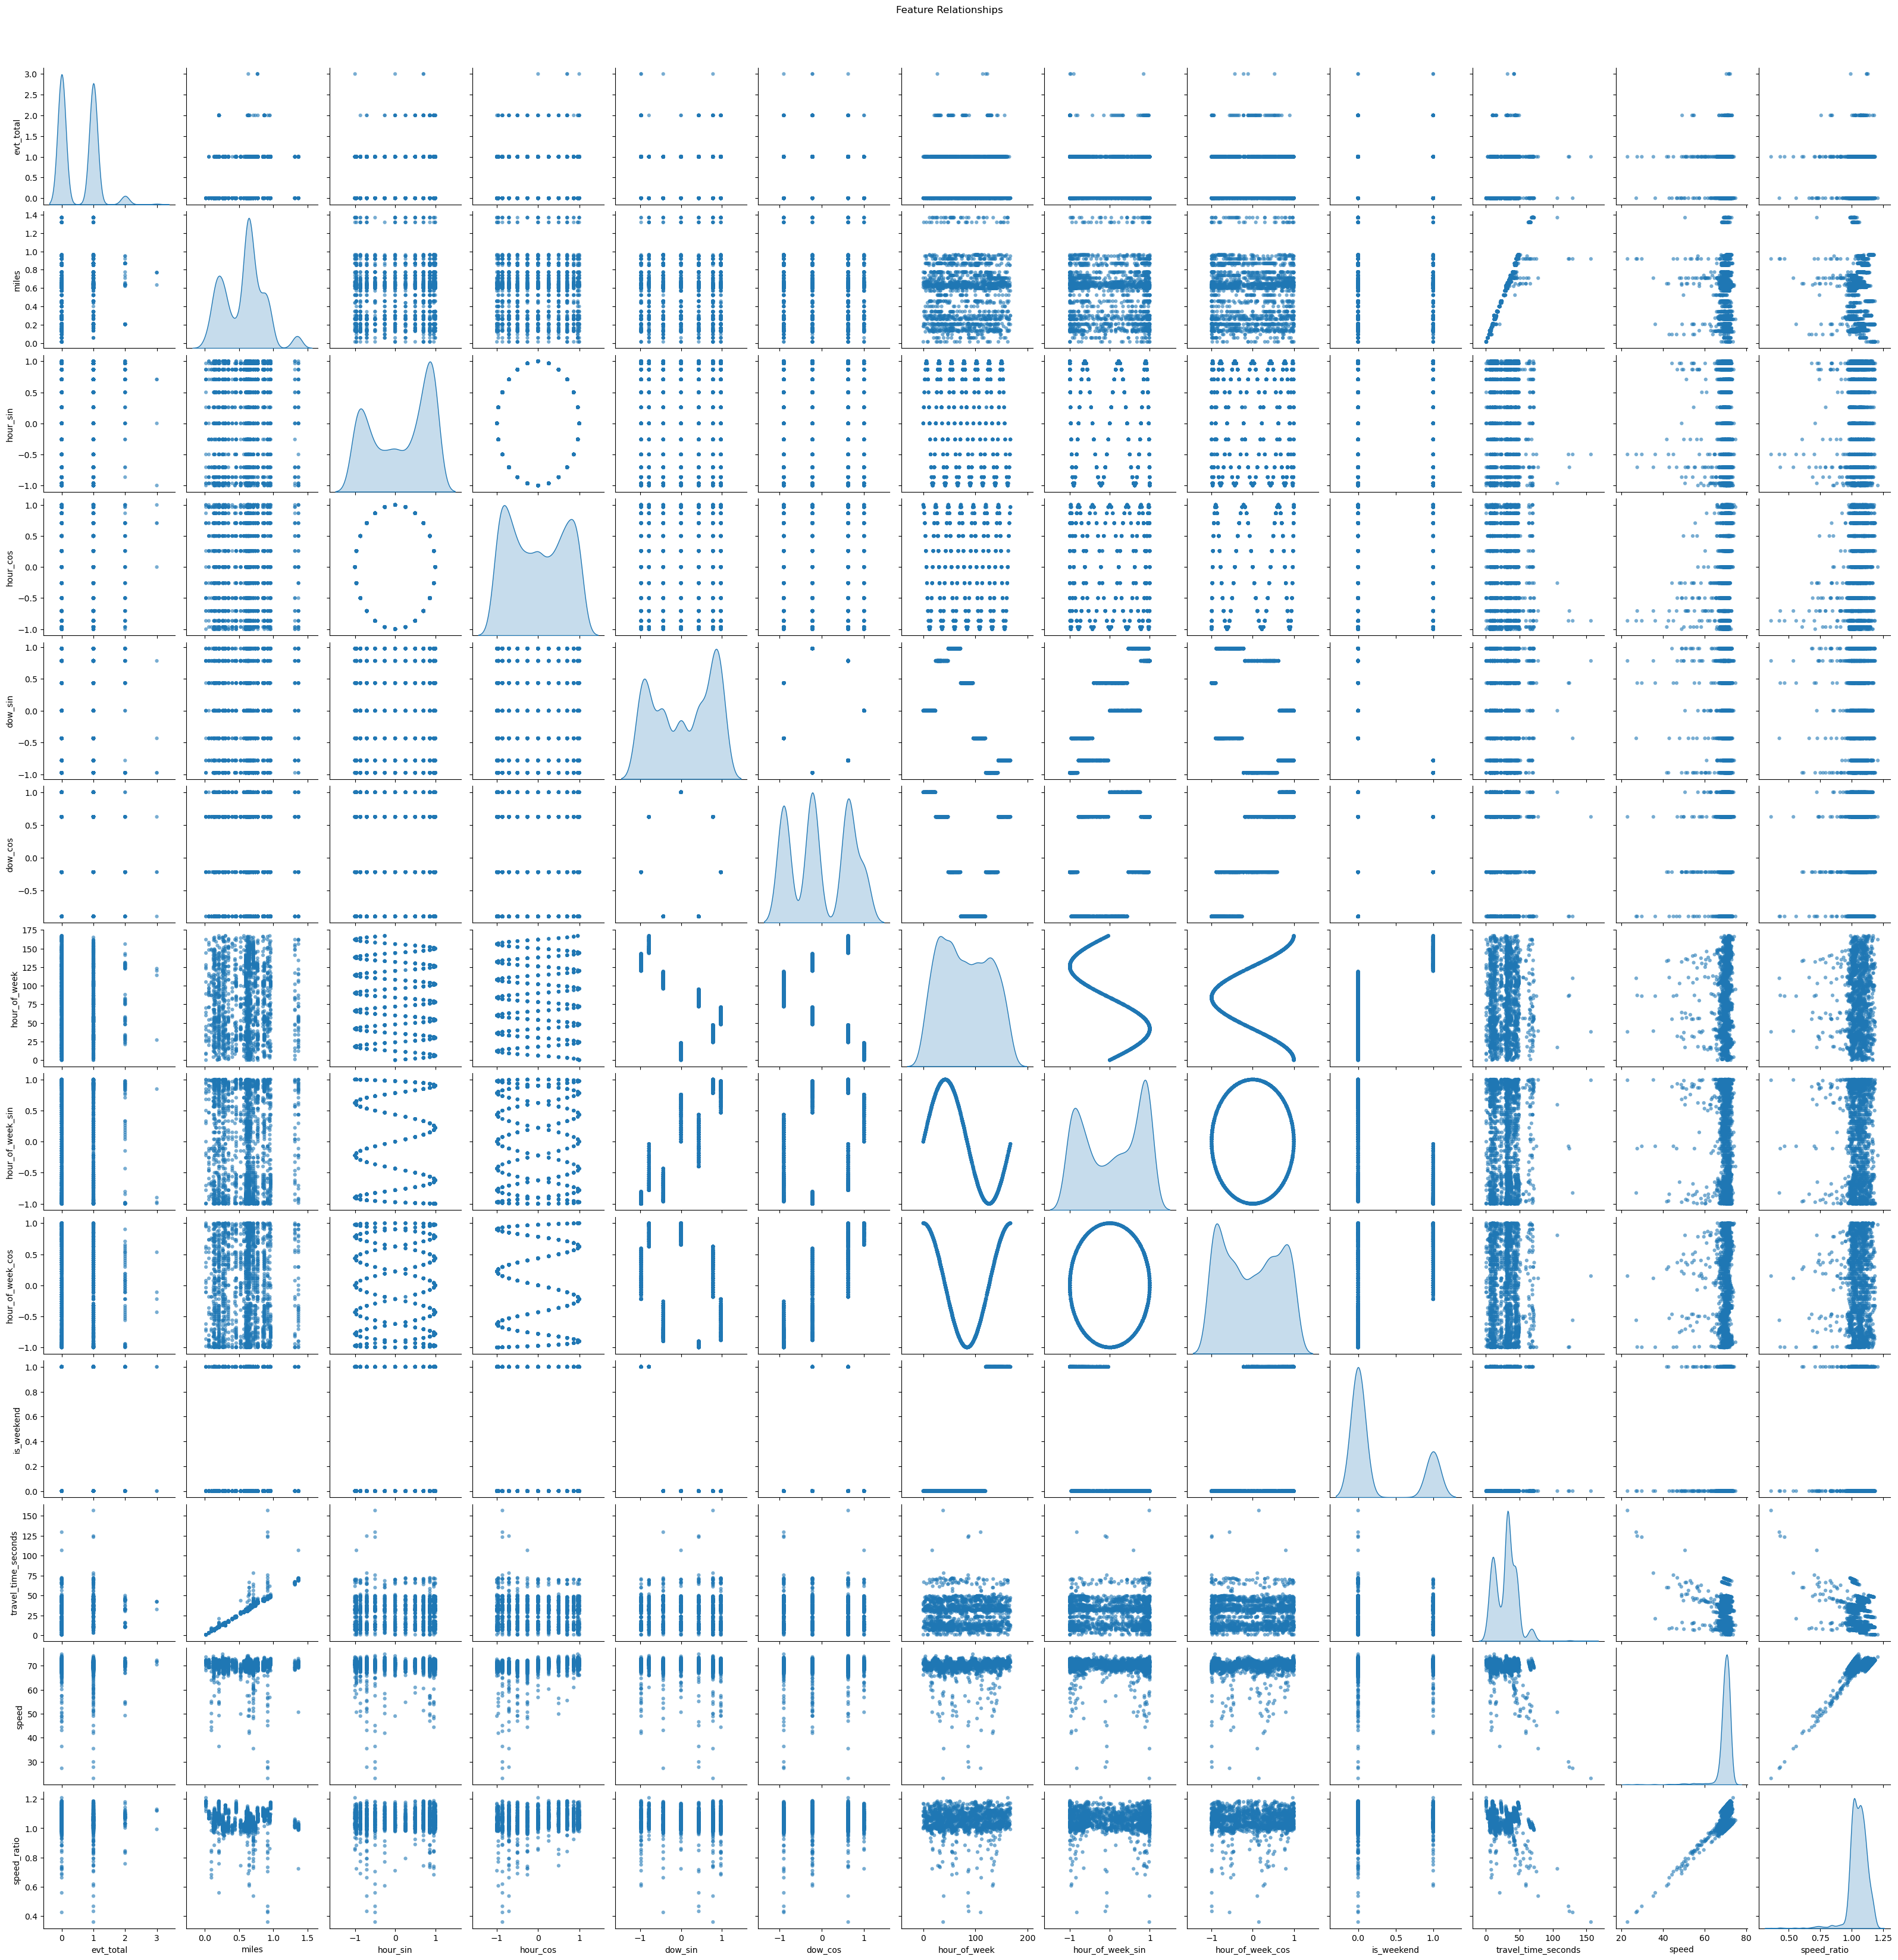

In [7]:
# use sns.pairplot to visualize the relationship between features and labels in X_full
# label
label_col = ['travel_time_seconds','speed','speed_ratio']
feature_cols = ['evt_total','miles', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos',
       'hour_of_week', 'hour_of_week_sin', 'hour_of_week_cos', 'is_weekend']

sample_df = df_balanced.sample(n=min(len(df_balanced), 3000), random_state=42)  # adjust sample size
sns.pairplot(
    sample_df,
    vars=feature_cols+label_col,
    # hue='any_event',
    diag_kind='kde',
    # palette='Set2',
    plot_kws={'alpha': 0.6, 's': 20, 'edgecolor': 'none'}
)

plt.suptitle("Feature Relationships", y=1.02)
plt.show()

In [7]:
# "flatten data" into training data X and labels y, ignore the continuity in time and space. Treat data in each time bin and each TMC as independent samples.
label_col = ['travel_time_seconds']
feature_cols = [c for c in df_balanced.columns if c not in ['travel_time_seconds','speed','evt_duration']]

df_flat = df_balanced.reset_index()

X = df_flat[feature_cols]#.copy()
y = df_flat[label_col]#.copy()

# Basic NA handling: drop rows with NA in y; impute X with median
mask_valid = X.notna().all(axis=1)
X = X[mask_valid]
y = y[mask_valid]

print("Features: ",feature_cols)
print('Feature shape:', X.shape, '| Label shape:', y.shape)

Features:  ['reference_speed', 'evt_cat_major', 'evt_cat_minor', 'evt_cat_closure', 'evt_cat_obstruction', 'evt_cat_misc', 'miles', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'hour_of_week', 'hour_of_week_sin', 'hour_of_week_cos', 'is_weekend', 'evt_total', 'speed_ratio', 'lag1', 'lag2', 'lag3']
Feature shape: (1752, 20) | Label shape: (1752, 1)


## Linear Regression Models

In [ ]:
# Train a LinearRegression model with Pipeline and StandardScaler
# Report the model cross-validation error on the training set and the test set.
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error
import time

time_features = ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'hour_of_week', 'hour_of_week_sin', 'hour_of_week_cos', 'is_weekend']
evt_features = ['evt_total', 'evt_cat_major', 'evt_cat_minor', 'evt_cat_closure', 'evt_cat_obstruction', 'evt_cat_misc']
lag_features = ['lag1', 'lag2', 'lag3']
tmc_features = ['miles']
full_features = time_features + evt_features + lag_features + tmc_features

def evaluate_model(name, model, X_train, y_train, X_test, y_test, cv=False):
    start = time.time()
    model.fit(X_train, y_train)
    fit_time = time.time() - start

    y_pred = model.predict(X_test)
    rmse = np.sqrt(root_mean_squared_error(y_test, y_pred))
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)

    if cv:
        cv_rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=5))

    return {
        'model': name,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'fit_time': fit_time,
        'cv_rmse_mean': cv_rmse.mean() if cv else 0,
        'cv_rmse_std': cv_rmse.std() if cv else 0
    }

# Split the data into training and test sets with shuffle (fix random seed for reproducibility)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

lr_models = {
    # --- Linear Regression with only miles ---
    'lr_base': Pipeline([
        ('select_scale', ColumnTransformer([
            ('num', StandardScaler(with_mean=False), tmc_features)
        ], remainder='drop')),
        ('linreg', LinearRegression())
    ]),
    # --- Linear Regression with only miles and lags ---
    'lr_base_lags': Pipeline([
        ('select_scale', ColumnTransformer([
            ('num', StandardScaler(with_mean=False), tmc_features + lag_features)
        ], remainder='drop')),
        ('linreg', LinearRegression())
    ]),

    # --- Linear Regression with all features ---
    'lr_full': Pipeline([
        ('select_scale', ColumnTransformer([
            ('num', StandardScaler(with_mean=False), full_features)
        ], remainder='drop')),
        ('linreg', LinearRegression())
    ]),

    # --- Linear Regression (no event features) ---
    'lr_cyc': Pipeline([
        ('select_scale', ColumnTransformer([
            ('num', StandardScaler(with_mean=False), time_features + tmc_features)
        ], remainder='drop')),
        ('linreg', LinearRegression())
    ]),
    # --- Linear Regression (no event features) with lags ---
    'lr_cyc_lags': Pipeline([
        ('select_scale', ColumnTransformer([
            ('num', StandardScaler(with_mean=False), time_features + tmc_features + lag_features)
        ], remainder='drop')),
        ('linreg', LinearRegression())
    ]),

    # --- Linear Regression (no cyclical time features) ---
    'lr_evt': Pipeline([
        ('select_scale', ColumnTransformer([
            ('num', StandardScaler(with_mean=False), evt_features + tmc_features)
        ], remainder='drop')),
        ('linreg', LinearRegression())
    ]),

     # --- Linear Regression (no cyclical time features) with lags ---
    'lr_evt_lags': Pipeline([
        ('select_scale', ColumnTransformer([
            ('num', StandardScaler(with_mean=False), evt_features + tmc_features + lag_features)
        ], remainder='drop')),
        ('linreg', LinearRegression())
    ]),

    # --- Linear Regression with interaction terms ---
    'lr_poly2': Pipeline([
        ('select_scale', ColumnTransformer([
            ('num', StandardScaler(with_mean=False), full_features)
        ], remainder='drop')),
        ('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)),
        ('linreg', LinearRegression())
    ]),

    # --- Ridge Regression ---
    'ridge_full': Pipeline([
        ('select_scale', ColumnTransformer([
            ('num', StandardScaler(with_mean=False), full_features)
        ], remainder='drop')),
        ('ridge', Ridge(alpha=1.0))
    ])
}

In [ ]:
# train and evaluate each model
results = []

for name, model in lr_models.items():
    metrics = evaluate_model(name, model, X_train, y_train, X_test, y_test, cv=True)
    results.append(metrics)

results_df = pd.DataFrame(results).sort_values('cv_rmse_mean')
print(results_df)

          model      rmse       mae        r2  fit_time  cv_rmse_mean  \
8    ridge_full  2.967192  1.320084  0.794921  0.004030      3.404498   
1  lr_base_lags  2.957832  1.213524  0.797497  0.006136      3.418667   
4   lr_cyc_lags  2.958716  1.281896  0.797255  0.003933      3.420170   
2       lr_full  2.962936  1.315164  0.796095  0.004936      3.424612   
6   lr_evt_lags  2.960992  1.231269  0.796630  0.003542      3.426735   
3        lr_cyc  3.360868  2.029362  0.662446  0.003841      4.508538   
5        lr_evt  3.378658  1.973535  0.655242  0.003474      4.565332   
0       lr_base  3.372275  1.932448  0.657840  0.004511      4.569672   
7      lr_poly2  1.573315  1.176772  0.983789  0.017789     10.138546   

   cv_rmse_std  
8     0.780876  
1     0.800654  
4     0.783850  
2     0.784194  
6     0.802340  
3     0.773672  
5     0.811474  
0     0.804525  
7     4.899463  


In [44]:
corr = df_balanced.corr()
print(corr['travel_time_seconds'])
# print(corr['speed'])

speed                 -0.370375
travel_time_seconds    1.000000
reference_speed        0.026800
evt_duration                NaN
evt_cat_major          0.082295
evt_cat_minor          0.157445
evt_cat_closure        0.127084
evt_cat_obstruction    0.030384
evt_cat_misc           0.032071
miles                  0.922388
hour_sin               0.048014
hour_cos              -0.057400
dow_sin               -0.035008
dow_cos               -0.038335
hour_of_week           0.027654
hour_of_week_sin      -0.041358
hour_of_week_cos      -0.025513
is_weekend             0.029834
evt_total              0.259980
speed_ratio           -0.322688
lag1                   0.961822
lag2                   0.939526
lag3                   0.898056
Name: travel_time_seconds, dtype: float64


## Tree-based models
Tree models don't need scaling

In [10]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# from xgboost import XGBRegressor

# Best params for rf_base: {'rf__max_depth': 12, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 5, 'rf__n_estimators': 200}
# Best params for rf_base_lags: {'rf__max_depth': 12, 'rf__max_features': 1.0, 'rf__min_samples_leaf': 10, 'rf__n_estimators': 300}
# Best params for rf_cyc: {'rf__max_depth': 18, 'rf__max_features': 1.0, 'rf__min_samples_leaf': 5, 'rf__n_estimators': 200}
# Best params for rf_cyc_lags: {'rf__max_depth': 12, 'rf__max_features': 1.0, 'rf__min_samples_leaf': 10, 'rf__n_estimators': 300}
# Best params for rf_full: {'rf__max_depth': 12, 'rf__max_features': 1.0, 'rf__min_samples_leaf': 10, 'rf__n_estimators': 300}
# Best params for gbrt_base: {'gbrt__learning_rate': 0.1, 'gbrt__max_depth': 3, 'gbrt__n_estimators': 200, 'gbrt__subsample': 0.8}
# Best params for gbrt_cyc: {'gbrt__learning_rate': 0.01, 'gbrt__max_depth': 3, 'gbrt__n_estimators': 300, 'gbrt__subsample': 0.8}
# Best params for gbrt_cyc_lags: {'gbrt__learning_rate': 0.05, 'gbrt__max_depth': 3, 'gbrt__n_estimators': 300, 'gbrt__subsample': 1.0}
# Best params for gbrt_evt: {'gbrt__learning_rate': 0.1, 'gbrt__max_depth': 3, 'gbrt__n_estimators': 200, 'gbrt__subsample': 0.8}
# Best params for gbrt_evt_lags: {'gbrt__learning_rate': 0.01, 'gbrt__max_depth': 6, 'gbrt__n_estimators': 500, 'gbrt__subsample': 0.8}
# Best params for gbrt_full: {'gbrt__learning_rate': 0.01, 'gbrt__max_depth': 3, 'gbrt__n_estimators': 500, 'gbrt__subsample': 1.0}
    
tree_models = {
    # --- Random Forest with only tmc features ---
    'rf_base': Pipeline([
        ('select', ColumnTransformer([
            ('num', 'passthrough', tmc_features)
        ], remainder='drop')),
        ('rf', RandomForestRegressor(
            n_estimators=300,
            max_depth=12,
            min_samples_leaf=5,
            n_jobs=-1,
            random_state=42
        ))
    ]),

    # --- Random Forest with only tmc features and lags ---
    'rf_base_lags': Pipeline([
        ('select', ColumnTransformer([
            ('num', 'passthrough', tmc_features + lag_features)
        ], remainder='drop')),
        ('rf', RandomForestRegressor(
            n_estimators=300,
            max_depth=12,
            min_samples_leaf=5,
            n_jobs=-1,
            random_state=42
        ))
    ]),

    # --- Random Forest with cyclical time features ---
    'rf_cyc': Pipeline([
        ('select', ColumnTransformer([
            ('num', 'passthrough', time_features + tmc_features)
        ], remainder='drop')),
        ('rf', RandomForestRegressor(
            n_estimators=300,
            max_depth=12,
            min_samples_leaf=5,
            n_jobs=-1,
            random_state=42
        ))
    ]),

    # --- Random Forest with cyclical time + lags features ---
    'rf_cyc_lags': Pipeline([
        ('select', ColumnTransformer([
            ('num', 'passthrough', time_features + tmc_features + lag_features)
        ], remainder='drop')),
        ('rf', RandomForestRegressor(
            n_estimators=300,
            max_depth=12,
            min_samples_leaf=5,
            n_jobs=-1,
            random_state=42
        ))
    ]),


    # --- Random Forest with full features ---
    'rf_full': Pipeline([
        ('select', ColumnTransformer([
            ('num', 'passthrough', full_features)
        ], remainder='drop')),
        ('rf', RandomForestRegressor(
            n_estimators=300,
            max_depth=12,
            min_samples_leaf=5,
            n_jobs=-1,
            random_state=42
        ))
    ]),


    # --- Gradient Boosting with base features ---
    'gbrt_base': Pipeline([
        ('select', ColumnTransformer([
            ('num', 'passthrough', tmc_features)
        ], remainder='drop')),
        ('gbrt', GradientBoostingRegressor(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=3,
            random_state=42
        ))
    ]),

    # --- Gradient Boosting with cyclical time features ---
    'gbrt_cyc': Pipeline([
        ('select', ColumnTransformer([
            ('num', 'passthrough', time_features + tmc_features)
        ], remainder='drop')),
        ('gbrt', GradientBoostingRegressor(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=3,
            random_state=42
        ))
    ]),

    # --- Gradient Boosting with cyclical time + lags features ---
    'gbrt_cyc_lags': Pipeline([
        ('select', ColumnTransformer([
            ('num', 'passthrough', time_features + tmc_features + lag_features)
        ], remainder='drop')),
        ('gbrt', GradientBoostingRegressor(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=3,
            random_state=42
        ))
    ]),

    # --- Gradient Boosting with event features ---
    'gbrt_evt': Pipeline([
        ('select', ColumnTransformer([
            ('num', 'passthrough', evt_features + tmc_features)
        ], remainder='drop')),
        ('gbrt', GradientBoostingRegressor(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=3,
            random_state=42
        ))
    ]),

    # --- Gradient Boosting with event features + lags ---
    'gbrt_evt_lags': Pipeline([
        ('select', ColumnTransformer([
            ('num', 'passthrough', evt_features + tmc_features + lag_features)
        ], remainder='drop')),
        ('gbrt', GradientBoostingRegressor(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=3,
            random_state=42
        ))
    ]),

    # --- Gradient Boosting  with full features ---
    'gbrt_full': Pipeline([
        ('select', ColumnTransformer([
            ('num', 'passthrough', full_features)
        ], remainder='drop')),
        ('gbrt', GradientBoostingRegressor(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=3,
            random_state=42
        ))
    ]),

}

In [56]:
# hyper param tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
for name, model in tree_models.items():
    param_grid = {}
    if 'rf' in name:
        param_grid = {
            'rf__n_estimators': [100, 200, 300, 500],
            'rf__max_depth': [6, 12, 18],
            'rf__min_samples_leaf': [1, 5, 10]
        }
    elif 'gbrt' in name:
        param_grid = {
            'gbrt__n_estimators': [200, 300, 500, 800],
            'gbrt__learning_rate': [0.01, 0.05, 0.1],
            'gbrt__max_depth': [3, 6, 9],
            'gbrt__subsample': [0.8, 1.0]
        }
    
    if param_grid:
        search = GridSearchCV(
            model,
            param_grid=param_grid,
            scoring='neg_mean_squared_error',
            cv=3,
            n_jobs=-1,
            # random_state=42
        )
        search.fit(X_train, y_train.values.ravel())
        print(f"Best params for {name}: {search.best_params_}")
        print(f"Best CV RMSE for {name}: {np.sqrt(-search.best_score_)}")
        # tree_models[name] = search.best_estimator_

Best params for rf_base: {'rf__max_depth': 12, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 5, 'rf__n_estimators': 200}
Best CV RMSE for rf_base: 4.526642343643453
Best params for rf_base_lags: {'rf__max_depth': 12, 'rf__max_features': 1.0, 'rf__min_samples_leaf': 10, 'rf__n_estimators': 300}
Best CV RMSE for rf_base_lags: 3.647907165960796
Best params for rf_cyc: {'rf__max_depth': 18, 'rf__max_features': 1.0, 'rf__min_samples_leaf': 5, 'rf__n_estimators': 200}
Best CV RMSE for rf_cyc: 4.298981275215289
Best params for rf_cyc_lags: {'rf__max_depth': 12, 'rf__max_features': 1.0, 'rf__min_samples_leaf': 10, 'rf__n_estimators': 300}
Best CV RMSE for rf_cyc_lags: 3.6232280833731165
Best params for rf_full: {'rf__max_depth': 12, 'rf__max_features': 1.0, 'rf__min_samples_leaf': 10, 'rf__n_estimators': 300}
Best CV RMSE for rf_full: 3.6258536591418484
Best params for gbrt_base: {'gbrt__learning_rate': 0.1, 'gbrt__max_depth': 3, 'gbrt__n_estimators': 200, 'gbrt__subsample': 0.8}
Best CV

In [11]:
# train and evaluate each model
results = []

for name, model in tree_models.items():
    metrics = evaluate_model(name, model, X_train, y_train.values.ravel(), X_test, y_test.values.ravel(), cv=False)
    results.append(metrics)

results_df = pd.DataFrame(results).sort_values('rmse')
print(results_df)

            model      rmse       mae        r2  fit_time  cv_rmse_mean  \
1    rf_base_lags  3.051853  1.325745  0.770495  3.337197             0   
3     rf_cyc_lags  3.075612  1.338733  0.763264  2.045171             0   
4         rf_full  3.076046  1.342694  0.763131  1.807045             0   
9   gbrt_evt_lags  3.112500  1.433044  0.751701  1.032878             0   
10      gbrt_full  3.256311  1.532671  0.702531  1.610503             0   
7   gbrt_cyc_lags  3.264808  1.505928  0.699414  1.754475             0   
5       gbrt_base  3.315671  1.795583  0.680241  0.150616             0   
0         rf_base  3.316009  1.806008  0.680110  0.338400             0   
6        gbrt_cyc  3.355739  1.828085  0.664501  0.633194             0   
8        gbrt_evt  3.364653  1.817808  0.660922  0.325560             0   
2          rf_cyc  3.365081  1.737693  0.660750  1.975752             0   

    cv_rmse_std  
1             0  
3             0  
4             0  
9             0  
10       

In [6]:
# Save the new trainig data
output_path = Path('../database/i10-broadway')
output_path.mkdir(parents=True, exist_ok=True)
X_full.to_parquet(output_path / 'X_full_1h.parquet')

In [ ]:
# Save trained models
import joblib
joblib.dump(lr_models, '../models/lr_models.pkl')
joblib.dump(tree_models, '../models/tree_models.pkl')